# 오버워치 2 점수판 분석 AI

In [1]:
import os
import pandas as pd


def prepare_scoreboard(defeat_, draw_, victory_):
    scoreboard_ = pd.concat([defeat_, draw_, victory_])
    scoreboard_.set_index(pd.Index((i, j) for i in range(len(scoreboard_) // 10) for j in range(10)), inplace=True)
    return scoreboard_


datapath = os.path.join('datasets', '')
range_ = range(3, 10)
defeat = pd.read_csv(datapath + 'defeat.csv', usecols=range_)
draw = pd.read_csv(datapath + 'draw.csv', usecols=range_)
victory = pd.read_csv(datapath + 'victory.csv', usecols=range_)
scoreboard = prepare_scoreboard(defeat, draw, victory)
scoreboard

E   A   D   DMG      H   MIT    GAME
0   0   7   3   6  5933   1068  6199  DEFEAT
    1   7   0  10  3601    747     0  DEFEAT
    2   9   1   6  4352      0     0  DEFEAT
    3   7   7   2  2332   6325     0  DEFEAT
    4   6   4   2  3410   5979   606  DEFEAT
...    ..  ..  ..   ...    ...   ...     ...
205 5  11   4  11  6977    645  6378  DEFEAT
    6  10   0  13  7389      0   592  DEFEAT
    7  15   0  13  9338   1985   556  DEFEAT
    8   8  14   8  2859  10260   291  DEFEAT
    9   1  14  10   158  12357     0  DEFEAT

[2060 rows x 7 columns]

In [2]:
scoreboard.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2060 entries, (0, 0) to (205, 9)
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E       2060 non-null   int64 
 1   A       2060 non-null   int64 
 2   D       2060 non-null   int64 
 3   DMG     2060 non-null   int64 
 4   H       2060 non-null   int64 
 5   MIT     2060 non-null   int64 
 6   GAME    2060 non-null   object
dtypes: int64(6), object(1)
memory usage: 128.8+ KB


In [3]:
scoreboard['GAME'].value_counts()

GAME
DEFEAT     1005
VICTORY    1005
DRAW         50
Name: count, dtype: int64

In [4]:
scoreboard.describe()

,E,A,D,DMG,H,MIT
count,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000
mean,14.137379,7.571845,6.473786,6381.562621,3957.406311,2359.639320
std,10.343027,8.816635,3.911949,4704.827095,5262.560387,4754.326158
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,4.000000,2730.000000,0.000000,0.000000
50%,13.000000,4.000000,6.000000,5427.500000,829.000000,245.000000
75%,20.000000,12.000000,9.000000,9465.000000,7604.000000,1801.250000
max,56.000000,48.000000,21.000000,29354.000000,27756.000000,41092.000000


In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
IMAGES_PATH = os.path.join('.', 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장:', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

In [6]:
tank = scoreboard[::10]
damage = pd.concat([scoreboard[1::10], scoreboard[2::10]])
support = pd.concat([scoreboard[3::10], scoreboard[4::10]])

그림 저장: tank_hist


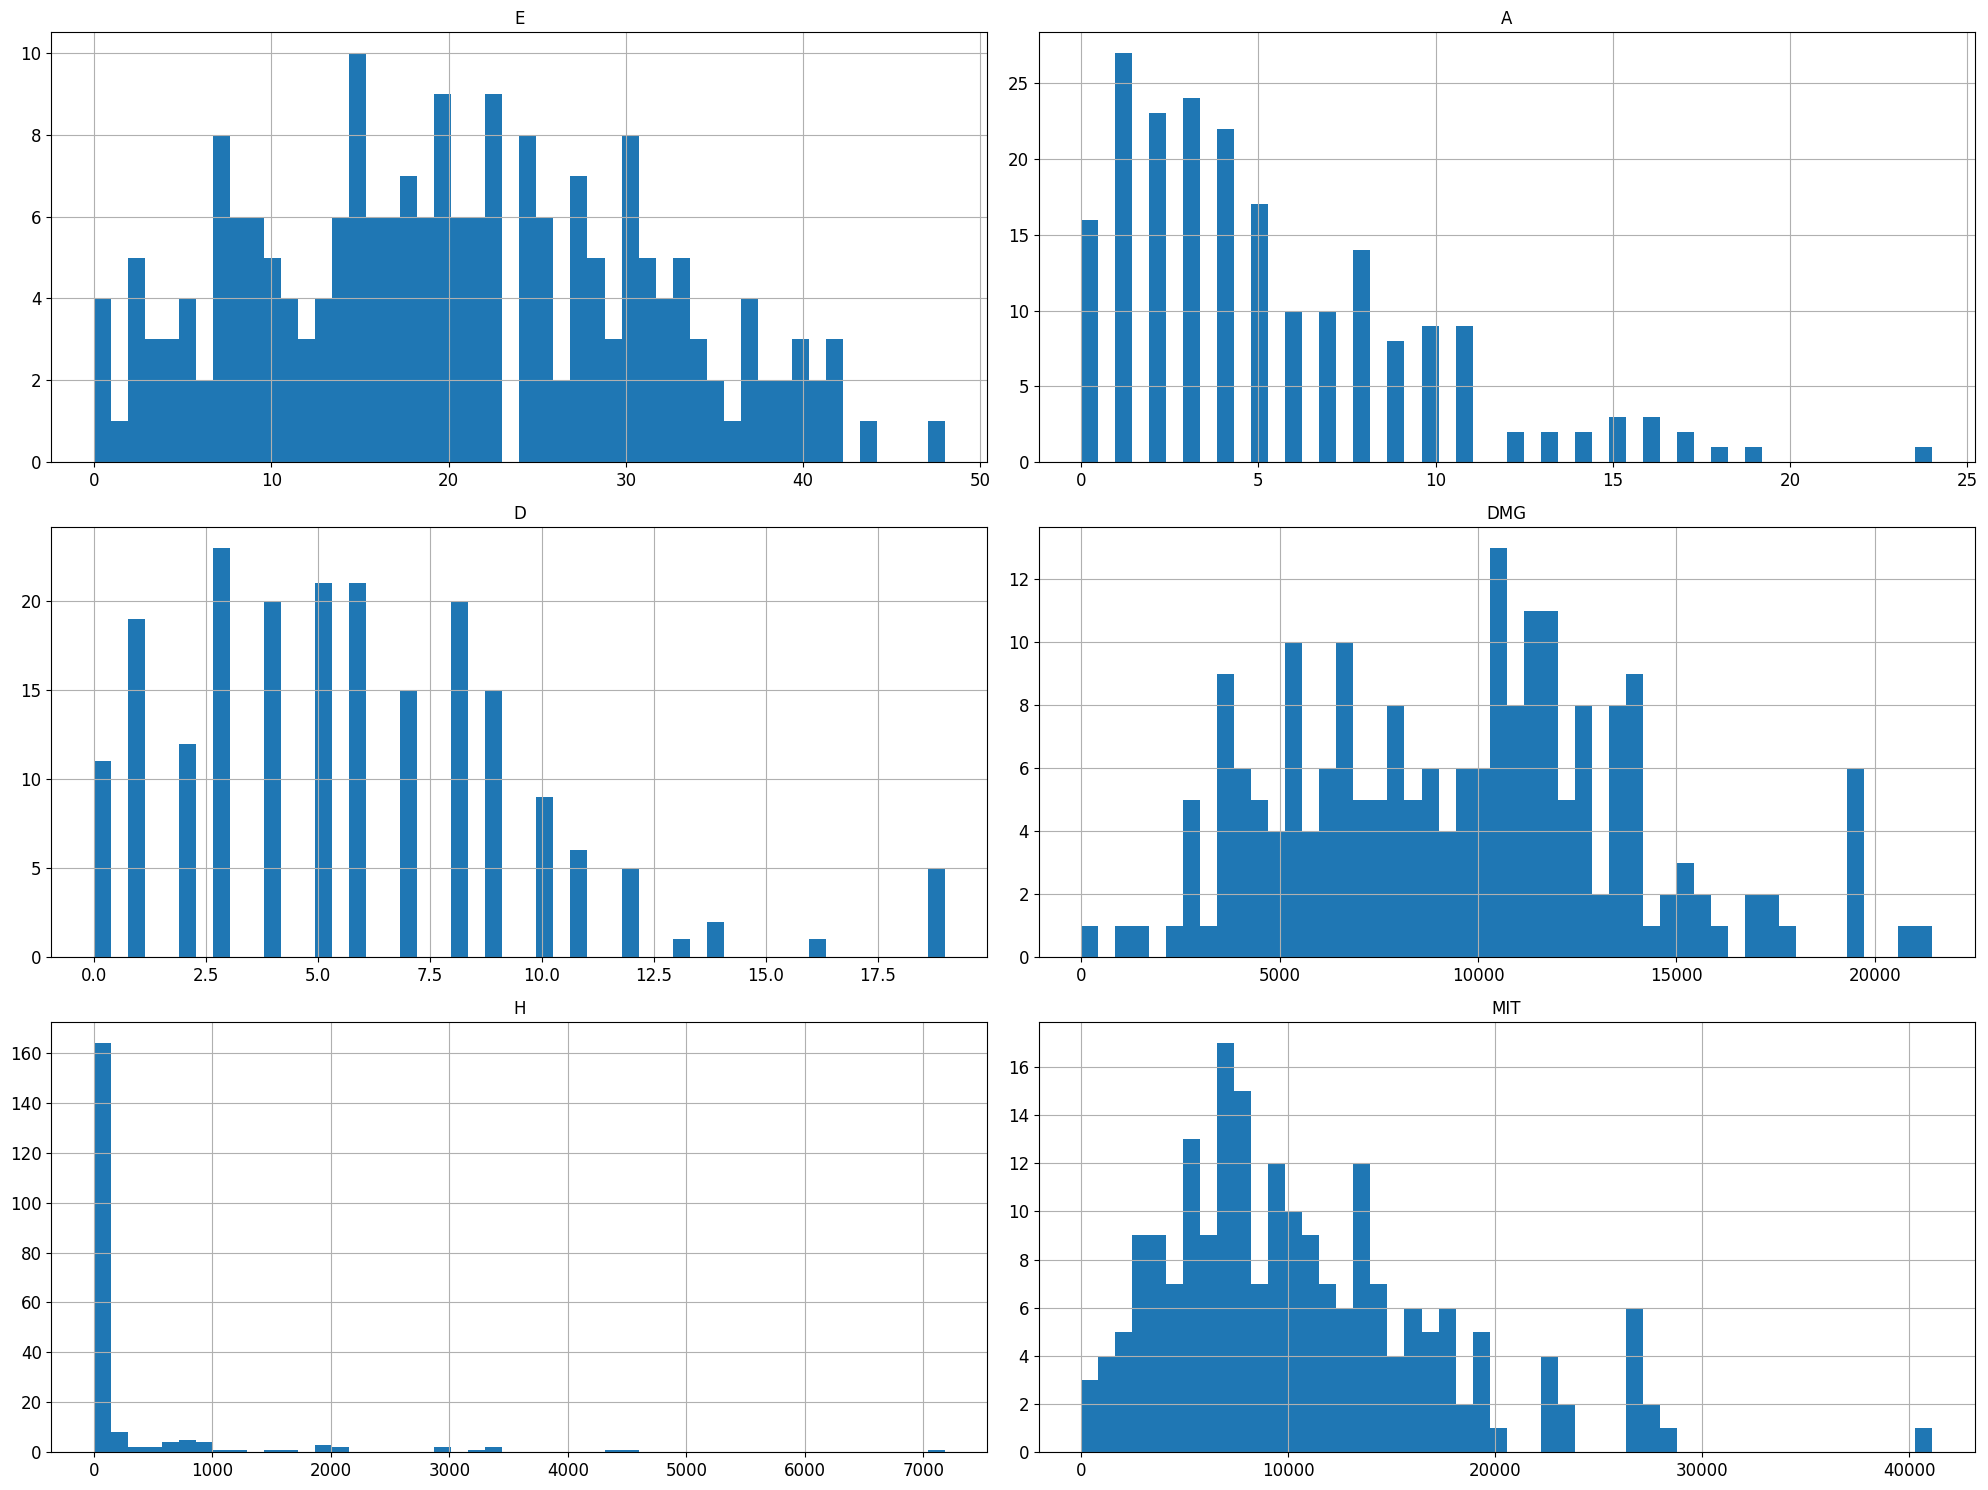

In [7]:
tank.hist(bins=50, figsize=(20, 15))
save_fig('tank_hist')
plt.show()

그림 저장: damage_hist


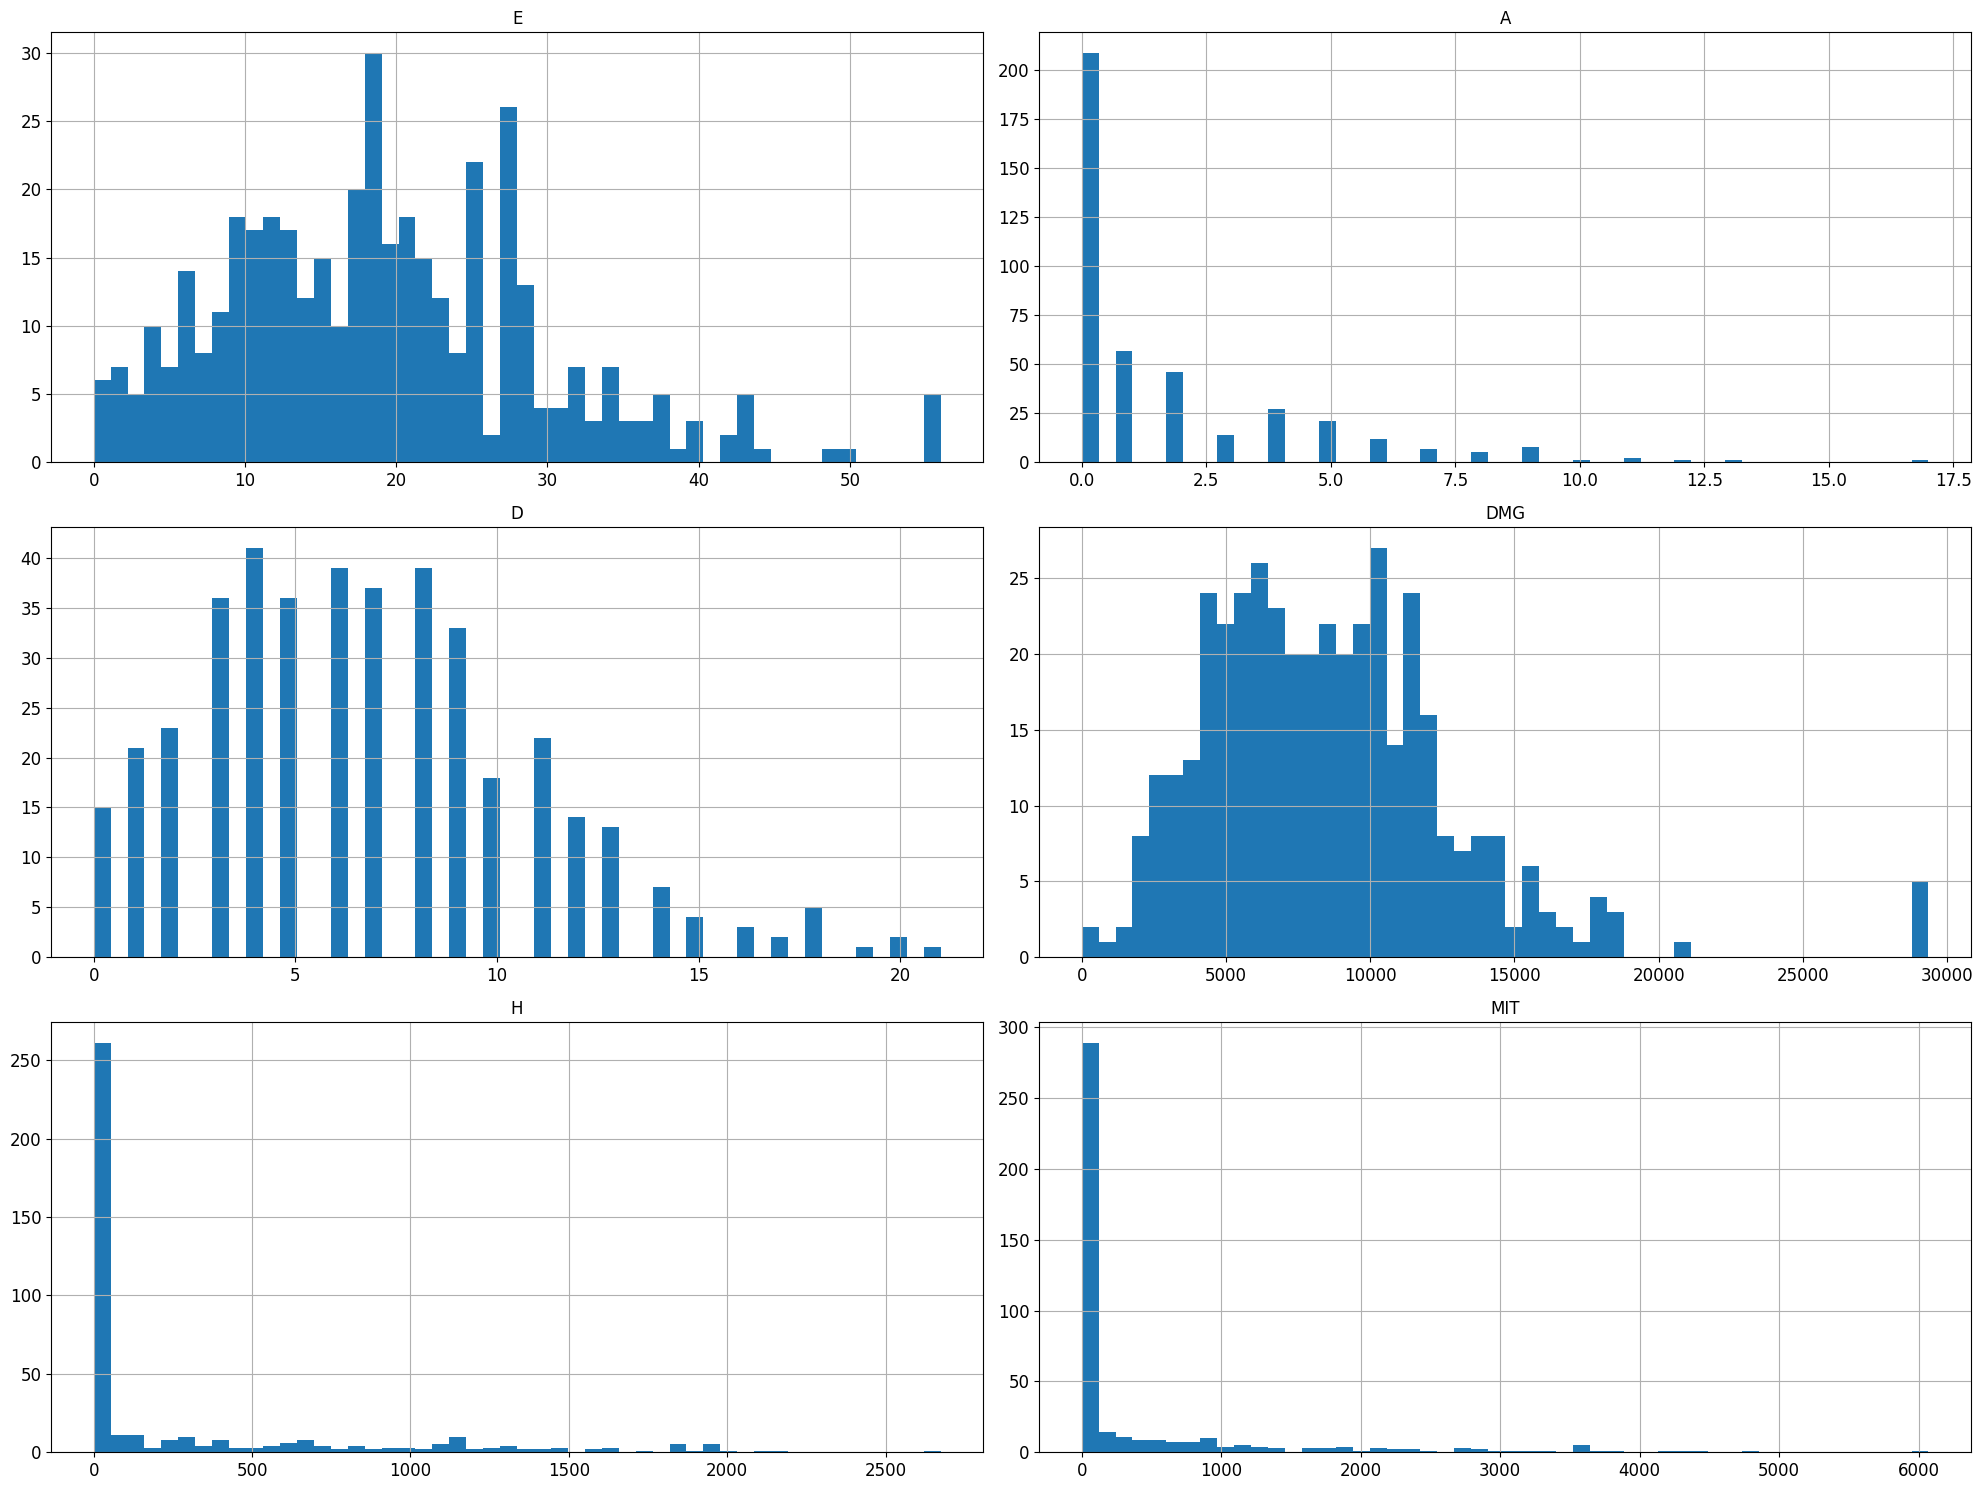

In [8]:
damage.hist(bins=50, figsize=(20, 15))
save_fig('damage_hist')
plt.show()

그림 저장: support_hist


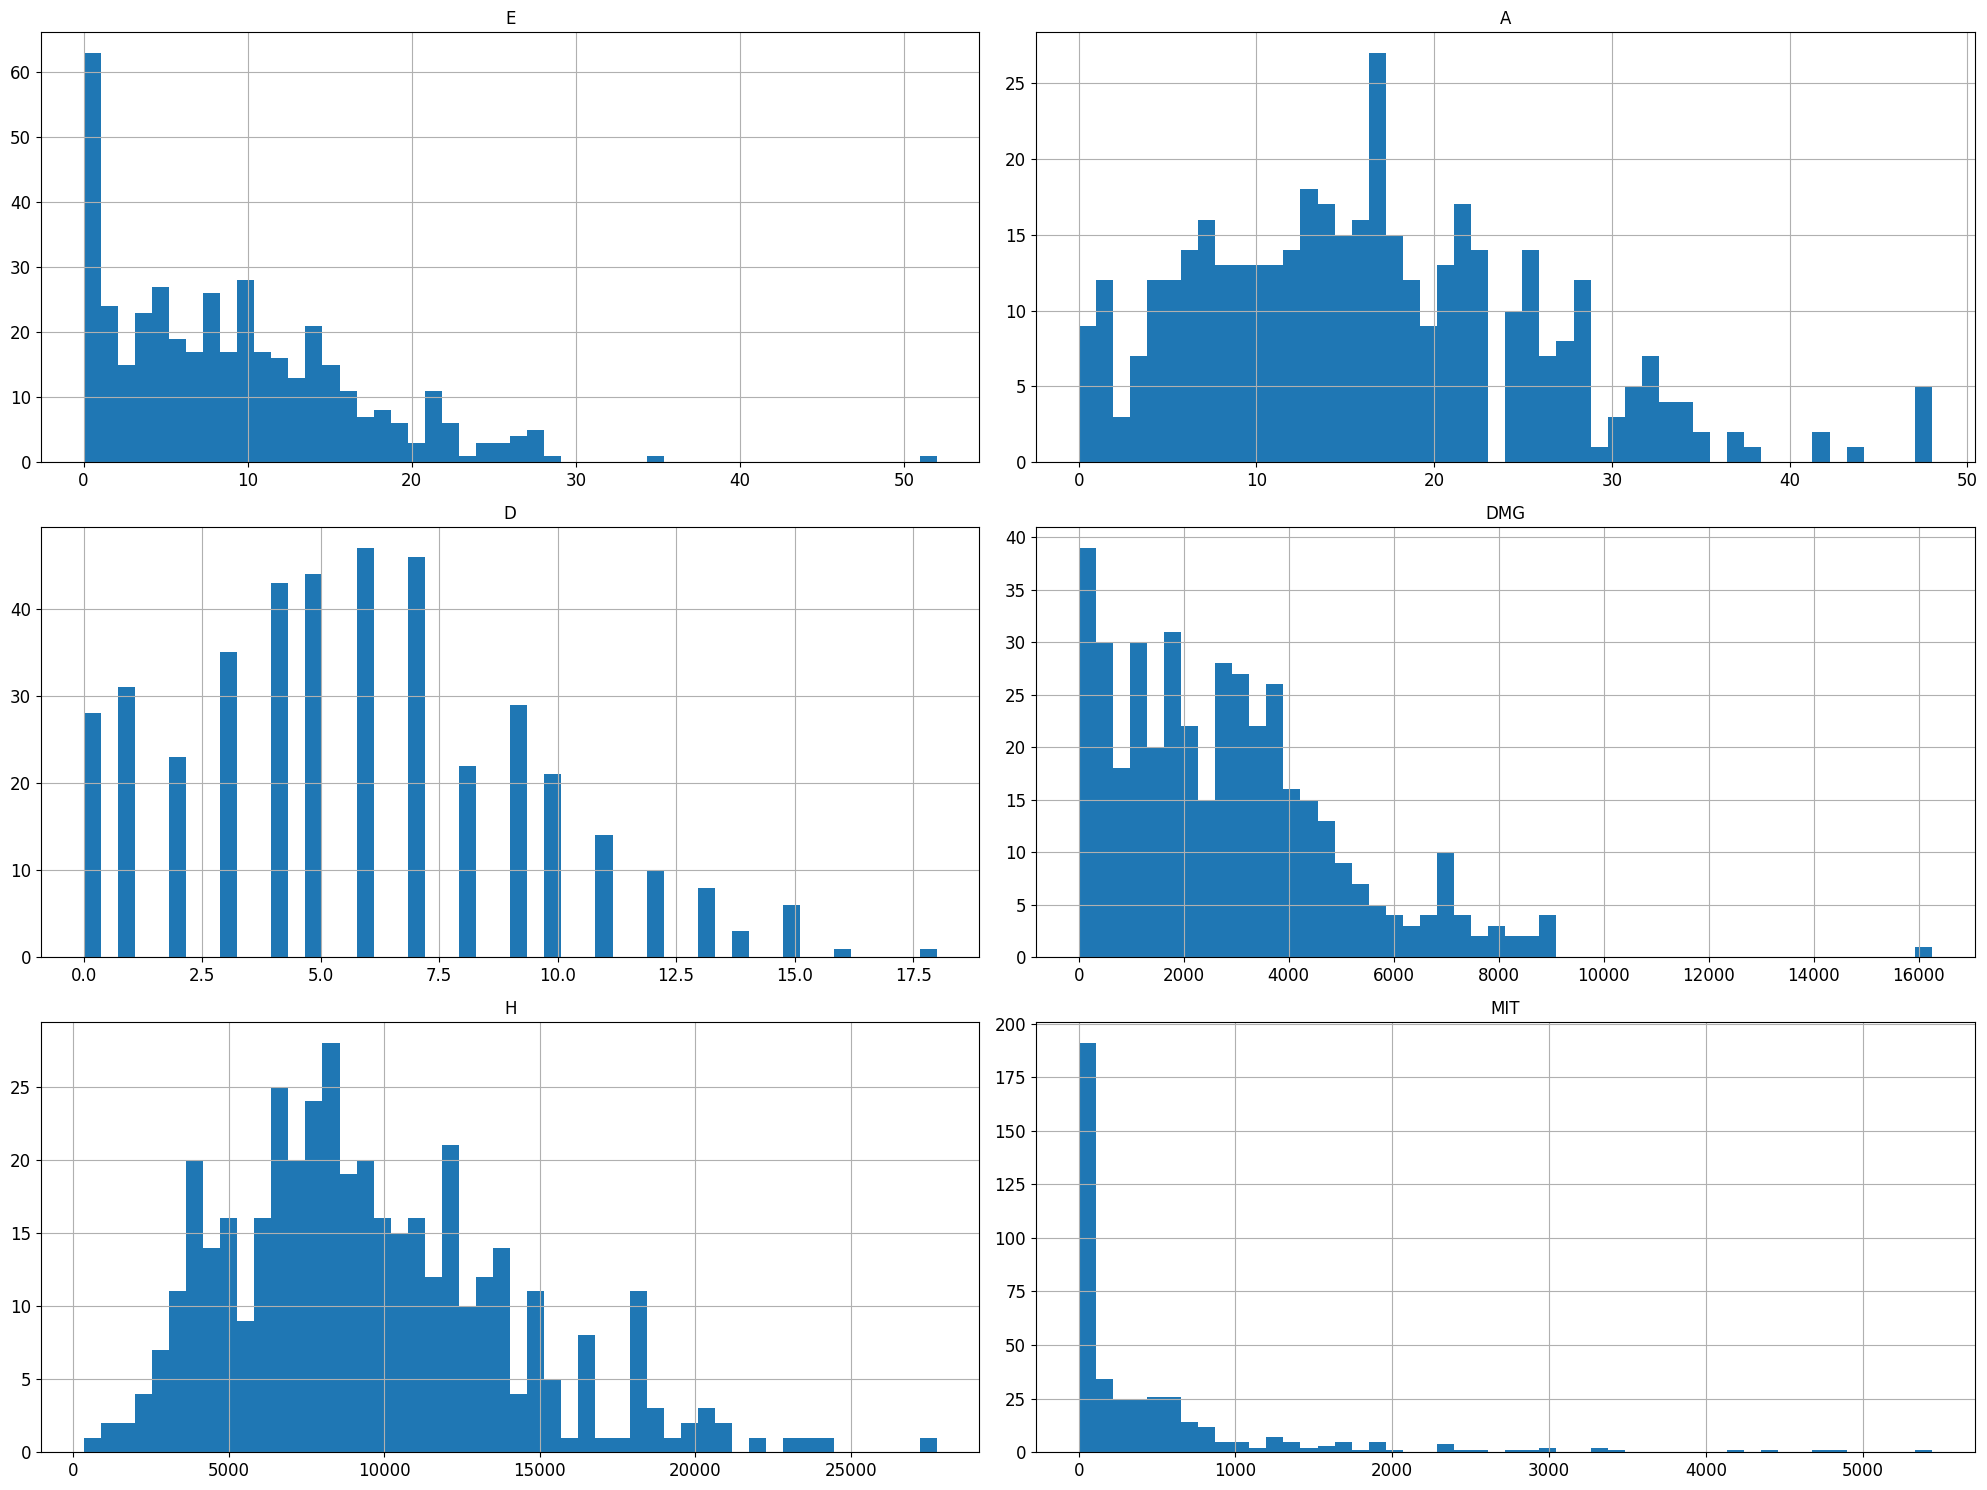

In [9]:
support.hist(bins=50, figsize=(20, 15))
save_fig('support_hist')
plt.show()

In [10]:
import numpy as np

train_set = scoreboard.loc[np.random.default_rng().permutation(len(scoreboard) // 10)]

In [11]:
scoreboard = train_set.copy()
# e = scoreboard['E'].copy()
# d = scoreboard['D'].copy()
# e[e == 0] = .5
# d[d == 0] = .5
# scoreboard['E_per_D'] = e / d
# scoreboard.describe()

In [12]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
scoreboard_cat = train_set[['GAME']]
scoreboard_cat_encoded = ordinal_encoder.fit_transform(scoreboard_cat)
scoreboard_cat_encoded[:10]

array([[2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [13]:
ordinal_encoder.categories_

[array(['DEFEAT', 'DRAW', 'VICTORY'], dtype=object)]

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

e_ix, a_ix, d_ix, dmg_ix = [scoreboard.columns.get_loc(c) for c in ('E', 'A', 'D', 'DMG')]
extra = ['E / D', 'A / D', 'D - E', 'D - A', 'E / DMG', 'D / DMG', 'E - D']


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.to_numpy(np.float64)
        e, a, d, dmg = X[:, e_ix], X[:, a_ix], X[:, d_ix], X[:, dmg_ix]
        e[e == 0], a[a == 0], d[d == 0], dmg[dmg == 0] = .5, .5, .5, .5
        return np.c_[X, e / d, a / d, d - e, d - a, e / dmg, d / dmg, e - d]


scoreboard_num = scoreboard.drop('GAME', axis=1)
attr_adder = CombinedAttributesAdder()
scoreboard_extra_attribs = attr_adder.transform(scoreboard_num)
scoreboard_extra_attribs = pd.DataFrame(
    scoreboard_extra_attribs, scoreboard_num.index, list(scoreboard_num) + extra
)
scoreboard_extra_attribs

E     A     D      DMG        H      MIT      E / D     A / D  \
121 0  34.0  18.0   3.0  12580.0      0.0  12164.0  11.333333  6.000000   
    1  29.0   4.0  10.0  11574.0     89.0    616.0   2.900000  0.400000   
    2  32.0   2.0  10.0  12780.0   2104.0      0.0   3.200000  0.200000   
    3  10.0  23.0   7.0   1675.0  12321.0    482.0   1.428571  3.285714   
    4  21.0  27.0   7.0   5140.0  14749.0      0.0   3.000000  3.857143   
...     ...   ...   ...      ...      ...      ...        ...       ...   
14  5  27.0   6.0   2.0  17860.0      0.0  14613.0  13.500000  3.000000   
    6  27.0   0.5  10.0   9288.0      0.0   1030.0   2.700000  0.050000   
    7  25.0   0.5   8.0  10367.0   1209.0      0.0   3.125000  0.062500   
    8   5.0  22.0   7.0   1814.0   7266.0    130.0   0.714286  3.142857   
    9  12.0  11.0   4.0   4483.0  11544.0   1183.0   3.000000  2.750000   

       D - E  D - A   E / DMG   D / DMG  E - D  
121 0  -31.0  -15.0  0.002703  0.000238   31.0  
    1  -19.0    6.0  0.002506  0.000864   19.0  
    2  -22.0    8.0  0.002504  0.000782   22.0  
    3   -3.0  -16.0  0.005970  0.004179    3.0  
    4  -14.0  -20.0  0.004086  0.001362   14.0  
...      ...    ...       ...       ...    ...  
14  5  -25.0   -4.0  0.001512  0.000112   25.0  
    6  -17.0    9.5  0.002907  0.001077   17.0  
    7  -17.0    7.5  0.002411  0.000772   17.0  
    8    2.0  -15.0  0.002756  0.003859   -2.0  
    9   -8.0   -7.0  0.002677  0.000892    8.0  

[2060 rows x 13 columns]

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('attribs_adder', CombinedAttributesAdder()), ('std_scaler', StandardScaler())])
scoreboard_num_tr = num_pipeline.fit_transform(scoreboard_num)
scoreboard_num_tr

array([[ 1.92481445,  1.18301458, -0.90247598, ..., -0.14104515,
        -0.08650841,  2.35507766],
       [ 1.43965419, -0.42284725,  0.90423006, ..., -0.14247711,
        -0.0857852 ,  1.14390326],
       [ 1.73075035, -0.65225608,  0.90423006, ..., -0.14248949,
        -0.08587946,  1.44669686],
       ...,
       [ 1.05152598, -0.82431271,  0.38802834, ..., -0.14316094,
        -0.08589194,  0.94204086],
       [-0.88911505,  1.64183224,  0.12992747, ..., -0.14065545,
        -0.08232269, -0.97565193],
       [-0.20989069,  0.38008366, -0.64437511, ..., -0.14123351,
        -0.08575253,  0.03366007]])

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

full_pipeline = ColumnTransformer(
    [('num', num_pipeline, scoreboard_num.columns), ('cat', OrdinalEncoder(), scoreboard_cat.columns)]
)
scoreboard_prepared = full_pipeline.fit_transform(train_set)
X = scoreboard_prepared[:, :-1]
shape_ = X.shape[-1]
X = X.reshape(-1, shape_ * 10)
y = scoreboard_prepared[::10, -1]

In [17]:
X

array([[ 1.92481445,  1.18301458, -0.90247598, ..., -0.14938681,
        -0.08363875, -1.07658313],
       [ 0.17823752, -0.65225608, -0.12817339, ..., -0.13322998,
        -0.08459996, -0.16820233],
       [-0.5980189 , -0.65225608, -0.12817339, ..., -0.10702149,
        -0.08166087, -0.57192713],
       ...,
       [-0.40395479, -0.7669605 , -0.38627425, ..., -0.14396498,
        -0.08578658, -0.26913353],
       [-0.20989069, -0.7669605 , -1.54772813, ...,  7.10495184,
         1.06936183, -0.77378953],
       [ 0.85746188, -0.19343842,  0.38802834, ..., -0.14123351,
        -0.08575253,  0.03366007]])

In [18]:
X.shape

(206, 130)

In [19]:
y

array([2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 2., 2., 2., 0., 0., 2.,
       2., 0., 2., 2., 0., 2., 2., 2., 2., 2., 2., 2., 0., 0., 2., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 2., 2., 2., 0., 0., 2., 0., 2., 2.,
       2., 0., 0., 2., 0., 2., 1., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0.,
       2., 0., 2., 2., 0., 2., 0., 2., 0., 2., 0., 2., 0., 1., 0., 2., 2.,
       0., 0., 2., 0., 0., 0., 2., 0., 0., 2., 2., 2., 2., 0., 2., 0., 0.,
       2., 0., 2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2.,
       0., 0., 0., 2., 2., 2., 2., 2., 0., 0., 2., 0., 0., 2., 2., 2., 0.,
       2., 0., 2., 0., 2., 0., 2., 0., 2., 2., 2., 2., 2., 2., 0., 2., 2.,
       2., 2., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 2., 2., 1., 2., 2.,
       0., 2., 2., 2., 2., 0., 2., 0., 2., 2., 2., 2., 2., 0., 0., 2., 0.,
       0., 2., 2., 0., 0., 2., 2., 0., 2., 0., 0., 2., 0., 2., 1., 2., 0.,
       2., 0.])

In [20]:
y.shape

(206,)

In [21]:
from sklearn import ensemble, linear_model, neighbors, svm, tree
from sklearn.model_selection import cross_val_score

models = {
    'AdaBoostClassifier': ensemble.AdaBoostClassifier(),
    'BaggingClassifier': ensemble.BaggingClassifier(n_jobs=-1),
    'ExtraTreesClassifier': ensemble.ExtraTreesClassifier(n_jobs=-1),
    'GradientBoostingClassifier': ensemble.GradientBoostingClassifier(),
    'RandomForestClassifier': ensemble.RandomForestClassifier(n_jobs=-1),
    'HistGradientBoostingClassifier': ensemble.HistGradientBoostingClassifier(),
    'LogisticRegression': linear_model.LogisticRegression(max_iter=500, n_jobs=-1),
    'PassiveAggressiveClassifier': linear_model.PassiveAggressiveClassifier(n_jobs=-1),
    'Perceptron': linear_model.Perceptron(n_jobs=-1),
    'RidgeClassifier': linear_model.RidgeClassifier(),
    'SGDClassifier': linear_model.SGDClassifier(n_jobs=-1),
    'KNeighborsClassifier': neighbors.KNeighborsClassifier(n_jobs=-1),
    'RadiusNeighborsClassifier': neighbors.RadiusNeighborsClassifier(16., n_jobs=-1),
    'NearestCentroid': neighbors.NearestCentroid(),
    'LinearSVC': svm.LinearSVC(dual='auto', max_iter=6000),
    'NuSVC': svm.NuSVC(nu=.09),
    'SVC': svm.SVC(),
    'DecisionTreeClassifier': tree.DecisionTreeClassifier(),
    'ExtraTreeClassifier': tree.ExtraTreeClassifier()
}
scores = {}
for k, v in models.items():
    scores[k] = cross_val_score(v, X, y, n_jobs=-1).mean()
sorted_ = sorted(scores.items(), key=lambda item: item[1], reverse=True)
sorted_

[('RandomForestClassifier', 0.9030197444831591),
 ('LogisticRegression', 0.8885017421602788),
 ('RadiusNeighborsClassifier', nan),
 ('SVC', 0.8981416957026713),
 ('ExtraTreesClassifier', 0.883739837398374),
 ('SGDClassifier', 0.8788617886178862),
 ('BaggingClassifier', 0.8787456445993032),
 ('RidgeClassifier', 0.8786295005807201),
 ('PassiveAggressiveClassifier', 0.8739837398373984),
 ('HistGradientBoostingClassifier', 0.8738675958188153),
 ('KNeighborsClassifier', 0.8738675958188153),
 ('NuSVC', 0.8737514518002323),
 ('NearestCentroid', 0.8691056910569106),
 ('GradientBoostingClassifier', 0.8689895470383275),
 ('LinearSVC', 0.859465737514518),
 ('Perceptron', 0.8545876887340302),
 ('DecisionTreeClassifier', 0.8153310104529616),
 ('AdaBoostClassifier', 0.8056910569105691),
 ('ExtraTreeClassifier', 0.776074332171893)]

In [22]:
from sklearn.model_selection import cross_val_predict

transform = full_pipeline.named_transformers_.cat.inverse_transform
model = models[sorted_[0][0]]
for i, (y_true, y_pred) in enumerate(
        zip(transform(y.reshape(-1, 1)), transform(cross_val_predict(model, X, y, n_jobs=-1).reshape(-1, 1)))
):
    y_true, y_pred = y_true[0], y_pred[0]
    if y_true != y_pred:
        i = scoreboard.iloc[i * 10].name[0]
        defeats = len(defeat) // 10
        total = defeats + len(draw) // 10
        next_ = i + 1
        if i < defeats:
            print(f'{y_true} ({next_}) -> {y_pred} ({i})')
        elif i < total:
            print(f'{y_true} ({next_ - defeats}) -> {y_pred} ({i})')
        else:
            print(f'{y_true} ({next_ - total}) -> {y_pred} ({i})')
        print(scoreboard.loc[i], end='\n\n')

DEFEAT (41) -> VICTORY (40)
    E   A   D    DMG      H   MIT     GAME
0  36   2  11  17848   1982  6284   DEFEAT
1  35   0   6  18042      0     0   DEFEAT
2  37   6   8  15274    400  1211   DEFEAT
3  15  22  11   6731  14901  1699   DEFEAT
4  19  28   7   7049  14850   472   DEFEAT
5  23  10   6  17708      0  7725  VICTORY
6  21   5  13  12103   1542  1506  VICTORY
7  34   1  16  15304   1817   300  VICTORY
8   2  24  13    946  17783   691  VICTORY
9  12  14  10   5718  16086   804  VICTORY

VICTORY (64) -> DEFEAT (166)
   E  A  D   DMG     H   MIT     GAME
0  6  1  1  4935     0  1896  VICTORY
1  4  0  1  2540     0     0  VICTORY
2  5  0  4  2127     0  1440  VICTORY
3  0  2  1   225  2644    58  VICTORY
4  0  4  2     0  3927     0  VICTORY
5  6  3  1  3472     0  1285   DEFEAT
6  7  0  2  3210     0     0   DEFEAT
7  0  0  0     0     0     0   DEFEAT
8  1  3  2   356  2152    64   DEFEAT
9  3  5  0  1283  2749   249   DEFEAT

VICTORY (17) -> DEFEAT (119)
    E   A   D    DMG 

In [23]:
for model, _ in sorted_:
    model = models[model].fit(X, y)
    if hasattr(model, 'feature_importances_'):
        print(model)
        importances = model.feature_importances_.reshape(-1, shape_)
        
        tank = importances[[0, 5]]
        damage = importances[[1, 2, 6, 7]]
        support = importances[[3, 4, 8, 9]]
        
        feature = '돌격 1인', '공격 1인', '지원 1인'
        
        print('\n**역할 중요도**')
        sum_ = tank.sum(), damage.sum() / 2, support.sum() / 2
        for s, f in sorted(zip(sum_, feature), reverse=True):
            print(f'{f}: {s}')

        feature = list(scoreboard_num) + extra
        
        print('\n**특성 중요도**')
        for s, f in sorted(zip(importances.sum(0), feature), reverse=True):
            print(f'{f}: {s}')
        
        print('\n**돌격 1인 특성 중요도**')
        for s, f in sorted(zip(tank.sum(0), feature), reverse=True):
            print(f'{f}: {s}')
        
        print('\n**공격 1인 특성 중요도**')
        for s, f in sorted(zip(damage.sum(0) / 2, feature), reverse=True):
            print(f'{f}: {s}')
        
        print('\n**지원 1인 특성 중요도**')
        for s, f in sorted(zip(support.sum(0) / 2, feature), reverse=True):
            print(f'{f}: {s}')
        
        break

RandomForestClassifier(n_jobs=-1)

**역할 중요도**
돌격 1인: 0.38297682485149503
공격 1인: 0.1707872826883786
지원 1인: 0.13772430488587398

**특성 중요도**
E / D: 0.22986404489274934
D / DMG: 0.12488253581833884
A / D: 0.1076364956829314
D - E: 0.10428841575777271
E - D: 0.10291310006157063
E / DMG: 0.08514028255260213
D - A: 0.0802401967802874
E: 0.039957697653320925
DMG: 0.03062777384462472
H: 0.027568576016585453
D: 0.024733269931560876
A: 0.021469505625057818
MIT: 0.0206781053825979

**돌격 1인 특성 중요도**
E / D: 0.12903148153440658
D / DMG: 0.06297896403523011
D - E: 0.0495215920265316
E - D: 0.049502604650809495
A / D: 0.022307270320896865
D - A: 0.017302034475413636
D: 0.010922444111741756
E / DMG: 0.010827397767878314
DMG: 0.007348953186166237
E: 0.0073312061437496925
H: 0.005406427254532649
A: 0.005269370697350255
MIT: 0.005227078646787859

**공격 1인 특성 중요도**
E / D: 0.03689750479929676
E / DMG: 0.03012615753450446
D / DMG: 0.02500826122864385
E - D: 0.018614803567584843
D - E: 0.018081938354355568
E: 0

* 처치 / 죽음: 4.2799548420643125
* 도움 / 죽음: 2.7389495022243944
* 죽음 - 처치: 1.9437550382813007
* 죽음 - 도움: 1.62896154752897
* 처치 / 피해: 1.5987024235982639
* 죽음 / 피해: 1.5458408779812933
* 처치 - 죽음: 1.0154069447939167

* E / D: 0.22986404489274934
* D / DMG: 0.12488253581833884
* A / D: 0.1076364956829314
* E / DMG: 0.08514028255260213